# MNIST with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
from scipy.special import softmax
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE

In [2]:
import vbranch as vb

In [3]:
save = False
model_id = 1
architecture = 'cnn'

## Load Data

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
input_dim = 784
num_classes = 10

In [6]:
if architecture == 'fcn':
    X_train = X_train.reshape([-1, input_dim])
    X_test = X_test.reshape([-1, input_dim])
elif architecture == 'cnn':
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

## Train

### Build Model

In [7]:
BATCH_SIZE = 32
EPOCHS = 10
STEPS_PER_EPOCH = 100
NUM_BRANCHES = 3
SHARED_FRAC = 0
model_path = os.path.join('models', 'vb-mnist-{}-B{:d}-S{:.2f}_{:d}'.format(architecture,
    NUM_BRANCHES, SHARED_FRAC, model_id))

In [8]:
model_path

'models/vb-mnist-cnn-B3-S0.00_1'

In [9]:
tf.reset_default_graph()

train_data = (X_train.astype('float32'), y_train_one_hot)
test_data = (X_test.astype('float32'), y_test_one_hot)

batch_size = tf.placeholder('int64', name='batch_size')

train_datasets = []
test_datasets = []
inputs = [None] * NUM_BRANCHES
labels_one_hot = [None] * NUM_BRANCHES
train_init_ops = []
test_init_ops = []

for i in range(NUM_BRANCHES):
    train_datasets.append(tf.data.Dataset.from_tensor_slices(train_data).\
        batch(batch_size).repeat().\
        shuffle(buffer_size=4*BATCH_SIZE))

    test_datasets.append(tf.data.Dataset.from_tensor_slices(test_data).\
        batch(batch_size))
    
    iterator = tf.data.Iterator.from_structure(train_datasets[i].output_types, 
                                           train_datasets[i].output_shapes)
    inputs[i], labels_one_hot[i] = iterator.get_next(name='input_'+str(i+1))    

    train_init_ops.append(iterator.make_initializer(train_datasets[i]))
    test_init_ops.append(iterator.make_initializer(test_datasets[i], 
                                                name='test_init_op_'+str(i+1)))

In [10]:
with tf.variable_scope('model_' + str(model_id), reuse=tf.AUTO_REUSE):
    if architecture == 'fcn':
        model = vb.sequential.vbranch_fcn(inputs,
            ([128]*NUM_BRANCHES, int(128*SHARED_FRAC)), ([10]*NUM_BRANCHES, int(10*SHARED_FRAC)),
            branches=NUM_BRANCHES)
    elif architecture == 'cnn':
        model = vb.sequential.vbranch_cnn(inputs, (num_classes, 0),
            ([16]*NUM_BRANCHES, int(16*SHARED_FRAC)), ([32]*NUM_BRANCHES, int(32*SHARED_FRAC)),
            branches=NUM_BRANCHES)

In [11]:
model.summary()

i   Layer name         Output shapes     Num param  
----------------------------------------------------
    Input              [None,28,28,1]               
----------------------------------------------------
    Input              [None,28,28,1]               
----------------------------------------------------
    Input              [None,28,28,1]               
----------------------------------------------------
0   conv2d_1_1         [None,26,26,16]   480        
                       [None,26,26,16]              
                       [None,26,26,16]              
----------------------------------------------------
1   bn_1_1             [None,26,26,16]   96         
                       [None,26,26,16]              
                       [None,26,26,16]              
----------------------------------------------------
2   relu_1_1           [None,26,26,16]   0          
                       [None,26,26,16]              
                       [None,26,26,16]        

In [12]:
model.output

[<tf.Tensor 'model_1/output_vb1:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'model_1/output_vb2:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'model_1/output_vb3:0' shape=(?, 10) dtype=float32>]

In [13]:
tf.global_variables()

[<tf.Variable 'model_1/conv2d_1_1_vb1_f:0' shape=(3, 3, 1, 16) dtype=float32_ref>,
 <tf.Variable 'model_1/conv2d_1_1_vb1_b:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model_1/conv2d_1_1_vb2_f:0' shape=(3, 3, 1, 16) dtype=float32_ref>,
 <tf.Variable 'model_1/conv2d_1_1_vb2_b:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model_1/conv2d_1_1_vb3_f:0' shape=(3, 3, 1, 16) dtype=float32_ref>,
 <tf.Variable 'model_1/conv2d_1_1_vb3_b:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model_1/bn_1_1_vb1_unique_to_unique_scale:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model_1/bn_1_1_vb1_unique_to_unique_beta:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model_1/bn_1_1_vb2_unique_to_unique_scale:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model_1/bn_1_1_vb2_unique_to_unique_beta:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model_1/bn_1_1_vb3_unique_to_unique_scale:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'model_1/bn_1_1_vb3_unique_to_unique_beta:0' shape=(16

### Declare Training Ops

In [14]:
def get_shared_unshared_vars():
    """
    Get shared variables (in order to later average gradients)
    and unshared variables (unique to each branch)"""
    
    shared_vars = []
    unshared_vars = [[] for i in range(NUM_BRANCHES)]
    
    for var in tf.global_variables():
        if 'shared_to_shared' in var.name:
            shared_vars.append(var)
        else:
            for i in range(NUM_BRANCHES):
                if 'vb'+str(i+1) in var.name:
                    unshared_vars[i].append(var)
            
    return shared_vars, unshared_vars

In [15]:
shared_vars, unshared_vars = get_shared_unshared_vars()

In [16]:
unshared_vars

[[<tf.Variable 'model_1/conv2d_1_1_vb1_f:0' shape=(3, 3, 1, 16) dtype=float32_ref>,
  <tf.Variable 'model_1/conv2d_1_1_vb1_b:0' shape=(16,) dtype=float32_ref>,
  <tf.Variable 'model_1/bn_1_1_vb1_unique_to_unique_scale:0' shape=(16,) dtype=float32_ref>,
  <tf.Variable 'model_1/bn_1_1_vb1_unique_to_unique_beta:0' shape=(16,) dtype=float32_ref>,
  <tf.Variable 'model_1/conv2d_1_2_vb1_f:0' shape=(3, 3, 16, 16) dtype=float32_ref>,
  <tf.Variable 'model_1/conv2d_1_2_vb1_b:0' shape=(16,) dtype=float32_ref>,
  <tf.Variable 'model_1/bn_1_2_vb1_unique_to_unique_scale:0' shape=(16,) dtype=float32_ref>,
  <tf.Variable 'model_1/bn_1_2_vb1_unique_to_unique_beta:0' shape=(16,) dtype=float32_ref>,
  <tf.Variable 'model_1/conv2d_2_1_vb1_f:0' shape=(3, 3, 16, 32) dtype=float32_ref>,
  <tf.Variable 'model_1/conv2d_2_1_vb1_b:0' shape=(32,) dtype=float32_ref>,
  <tf.Variable 'model_1/bn_2_1_vb1_unique_to_unique_scale:0' shape=(32,) dtype=float32_ref>,
  <tf.Variable 'model_1/bn_2_1_vb1_unique_to_unique_bet

In [17]:
# Multi output loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

losses = []
# Store gradients from shared variables over each branch
shared_grads = []
unshared_train_ops = []

for i in range(NUM_BRANCHES):
    loss = vb.losses.softmax_cross_entropy_with_logits(labels=labels_one_hot[i], 
                                                       logits=model.output[i], 
                                                       name='loss_'+str(i+1))
    losses.append(loss)
    
    # Compute gradients of shared vars for each branch (but don't apply)
    if len(shared_vars) > 0:
        shared_grads.append(optimizer.compute_gradients(loss, var_list=shared_vars))
        
    # Apply gradients for unshared vars for each branch
    if len(unshared_vars[i]) > 0:
        unshared_train_ops.append(optimizer.minimize(loss, var_list=unshared_vars[i]))

In [18]:
# Take average of the gradients over each branch
mean_shared_grads = []

for v, var in enumerate(shared_vars):
    grad = tf.reduce_mean([shared_grads[i][v][0] for i in range(NUM_BRANCHES)], [0])
    mean_shared_grads.append((grad, var))
    
if len(shared_vars) > 0:
    shared_train_op = optimizer.apply_gradients(mean_shared_grads)
else:
    shared_train_op = []

In [19]:
mean_shared_grads

[]

In [20]:
train_ops = [unshared_train_ops, shared_train_op]

In [21]:
# Train accuracies
train_acc_ops = []
for i in range(NUM_BRANCHES):
    pred_max = tf.one_hot(tf.argmax(tf.nn.softmax(model.output[i]), axis=-1), 
                          num_classes)
    train_acc_op = tf.reduce_mean(tf.reduce_sum(labels_one_hot[i]*pred_max, [1]), 
                                  name='train_acc_'+str(i+1))
    train_acc_ops.append(train_acc_op)

# Test accuracy
pred = tf.nn.softmax(tf.reduce_mean(model.output, [0]))
pred_max = tf.one_hot(tf.argmax(pred, axis=-1), num_classes)
test_acc_op = tf.reduce_mean(tf.reduce_sum(labels_one_hot[0]*pred_max, [1]), 
                             name='test_acc')

### Run Ops

In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)
        
        sess.run(train_init_ops, feed_dict={batch_size: BATCH_SIZE})

        for i in range(STEPS_PER_EPOCH):
            _, train_losses, train_accs = sess.run([train_ops, losses, 
                                                 train_acc_ops])
            
            prog_vals = [('loss_'+str(b+1),train_losses[b]) for b in range(NUM_BRANCHES)]
            prog_vals += [('acc_'+str(b+1),train_accs[b]) for b in range(NUM_BRANCHES)]
            
            if i == STEPS_PER_EPOCH - 1:
                sess.run(test_init_ops, feed_dict={batch_size: len(X_test)})
                val_losses, val_acc, indiv_accs = sess.run([losses, test_acc_op, 
                                                            train_acc_ops])
                
                prog_vals += [("val_loss", np.mean(val_losses)), ("val_acc", val_acc)] + \
                    [('ind_acc_'+str(b+1), indiv_accs[b]) for b in range(NUM_BRANCHES)]
            
            progbar.update(i+1, values=prog_vals)
    
    if save:
        saver = tf.train.Saver()
        path = os.path.join(model_path, 'ckpt')
        saver.save(sess, path)

Epoch 1/10
100/100 [==============================] - 72s 720ms/step - loss_1: 1.2177 - loss_2: 1.2684 - loss_3: 1.2675 - acc_1: 0.6584 - acc_2: 0.6525 - acc_3: 0.6472 - val_loss: 0.6002 - val_acc: 0.9293 - ind_acc_1: 0.9090 - ind_acc_2: 0.8919 - ind_acc_3: 0.8687
Epoch 2/10
100/100 [==============================] - 39s 385ms/step - loss_1: 0.4526 - loss_2: 0.5087 - loss_3: 0.5113 - acc_1: 0.8991 - acc_2: 0.8984 - acc_3: 0.8866 - val_loss: 0.3120 - val_acc: 0.9603 - ind_acc_1: 0.9387 - ind_acc_2: 0.9375 - ind_acc_3: 0.9343
Epoch 3/10
100/100 [==============================] - 37s 373ms/step - loss_1: 0.2670 - loss_2: 0.2956 - loss_3: 0.3207 - acc_1: 0.9416 - acc_2: 0.9287 - acc_3: 0.9216 - val_loss: 0.2226 - val_acc: 0.9684 - ind_acc_1: 0.9509 - ind_acc_2: 0.9502 - ind_acc_3: 0.9443
Epoch 4/10
100/100 [==============================] - 41s 407ms/step - loss_1: 0.2211 - loss_2: 0.2303 - loss_3: 0.2332 - acc_1: 0.9459 - acc_2: 0.9428 - acc_3: 0.9384 - val_loss: 0.1956 - val_acc: 0.9680 

## Load Model

In [12]:
test_init_ops = ['test_init_op_'+str(i+1) for i in range(NUM_BRANCHES)]
losses = ['loss_'+str(i+1)+':0' for i in range(NUM_BRANCHES)]
train_acc_ops = ['train_acc_'+str(i+1)+':0' for i in range(NUM_BRANCHES)]

inputs = ['input_{}:0'.format(i+1) for i in range(NUM_BRANCHES)]
labels_one_hot = ['input_{}:1'.format(i+1) for i in range(NUM_BRANCHES)]
outputs = ['model_{}/output_vb{}:0'.format(model_id, i+1) for i in range(NUM_BRANCHES)]

In [14]:
with tf.Session() as sess:
    model_path = os.path.join('models', 'vb-mnist-{}-B{:d}-S{:.2f}_{:d}'.format(architecture,
        NUM_BRANCHES, SHARED_FRAC, model_id))
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

    sess.run(test_init_ops, feed_dict={'batch_size:0': len(X_test)})
    val_losses, val_acc, indiv_accs = sess.run([losses, 'test_acc:0', train_acc_ops])
    
    sample_size = 250
    sess.run(test_init_ops, feed_dict={'batch_size:0':sample_size})
    X_test_samples, y_test_samples, features = sess.run([inputs, labels_one_hot, outputs])

INFO:tensorflow:Restoring parameters from models/vb-mnist-cnn-B3-S0.00_1/ckpt


In [15]:
print('Loss:', np.mean(val_losses))
print('Acc:', val_acc)
print('Indiv accs:', indiv_accs)

Loss: 0.107025385
Acc: 0.9785
Indiv accs: [0.9718, 0.9675, 0.9655]


## Feature Visualization

In [16]:
mean_features = np.mean(features, axis=0)
print(mean_features.shape)

(250, 10)


In [17]:
start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(mean_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.006s...
[t-SNE] Computed neighbors for 250 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 5.721582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.897591
[t-SNE] KL divergence after 300 iterations: 0.223319
t-SNE done! Time elapsed: 0.638002872467041 seconds


In [18]:
labels = np.argmax(y_test_samples[0], axis=-1)

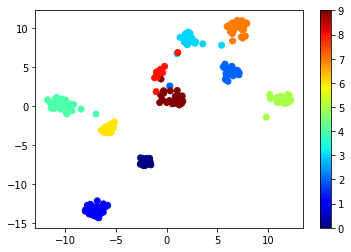

In [19]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap=plt.cm.jet)
plt.colorbar()
plt.show()